## Initialisation: Installation des modules requis

In [4]:
import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install librosa
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install h5py
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install pydub
# installer libav ou ffmpeg

In [1]:
from pydub import AudioSegment
import os
import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.layers import Convolution1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

C:\Users\Max\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Etape 1: Découpage de l'audio

### Définition des fonctions de découpe et de sauvegarde

In [3]:
# Découpe la base de données originale selon les moments bee ou nobee
original_sound_datasetpath = "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/OriginalTestDataset/Sound"
original_lab_datasetpath = "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/OriginalTestDataset/.lab"
fulldatasetpath = "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/TestDataset"

# Enregistre l'audio


def save_audio(newAudio, audio_file_name, condition, j, k=None):
    if 'Missing Queen' in audio_file_name or 'NO_QueenBee' in audio_file_name:
        if condition == "bee\n":
            newAudio.export(str(fulldatasetpath + '/' + 'missing queen'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
    elif 'NO_QueenBee' not in audio_file_name and 'QueenBee' in audio_file_name:
        if condition == "bee\n":
            newAudio.export(str(fulldatasetpath + '/' + 'queen bee'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
    else:
        if condition == "bee\n":
            newAudio.export(str(fulldatasetpath + '/' + 'bee'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")

#Enregistre les audios composites
def save_audio_mix(newAudio, audio_file_name, condition, j, k):
    if 'Missing Queen' in audio_file_name or 'NO_QueenBee' in audio_file_name:
        if (condition == "bee\n" and k < 3 ) or (condition == "nobee\n" and k > 1):
            newAudio.export(str(fulldatasetpath + '/' + 'missing queen'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
    elif 'NO_QueenBee' not in audio_file_name and 'QueenBee' in audio_file_name:
        if (condition == "bee\n" and k < 3) or (condition == "nobee\n" and k > 1):
            newAudio.export(str(fulldatasetpath + '/' + 'queen bee'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
    else:
        if (condition == "bee\n" and k < 3) or (condition == "nobee\n" and k > 1):
            newAudio.export(str(fulldatasetpath + '/' + 'bee'+'/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")
        else:
            newAudio.export(str(fulldatasetpath + '/' + 'nobee' + '/' +
                                audio_file_name + '_n' + str(j) + '_'+str(k)+'.wav'), format="wav")

# Découpe le fichier .wav associé au fichier.lab dont l'adresse est mise en entrée selon les moments bee ou nobee


def file_split(adresse_lab):
    # obtenir le nom et l'adresse du fichier audio associé
    text = open(adresse_lab, mode="r").readlines()
    del text[-1]  # On enlève le point final
    text[0] = text[0].rstrip()
    audio_file_name = text[0]
    audio_file_path = str(original_sound_datasetpath + '/' + audio_file_name + '.wav')
    # Reccueillir les temps des extraits
    n = len(text)
    for j in range(1, n):
        text[j] = text[j].split('\t')
        text[j][0] = float(text[j][0])
        text[j][1] = float(text[j][1])
    # On découpe et on enregistre les extraits

    for j in range(1, n):
        t1 = text[j][0] * 1000  # Works in milliseconds
        t2 = text[j][1] * 1000
        # Ici, on effectue des enregistrements d'une durée constante (condition nécessaire pour le réseau de neurones)
        audio_length=4000 #durée des enregistrements que l'on veut avoir
        if t2-t1 >= audio_length:
            k = 0
            while t1 + audio_length <= t2:
                newAudio = AudioSegment.from_wav(audio_file_path)
                newAudio = newAudio[t1:t1+audio_length]
                save_audio(newAudio, audio_file_name, text[j][2], j, k)
                t1 += audio_length/10  # Avec recouvrement et étoffement de la BDD
                k += 1
                print(audio_file_name, j, k)

#Créer des audio composites
def file_split_mix(adresse_lab):
    # obtenir le nom et l'adresse du fichier audio associé
    text = open(adresse_lab, mode="r").readlines()
    del text[-1]  # On enlève le point final
    text[0] = text[0].rstrip()
    audio_file_name = text[0]
    audio_file_path = str(original_sound_datasetpath + '/' + audio_file_name + '.wav')
    # Reccueillir les temps des extraits
    n = len(text)
    for j in range(1, n):
        text[j] = text[j].split('\t')
        text[j][0] = float(text[j][0])
        text[j][1] = float(text[j][1])
    # On découpe et on enregistre les extraits

    for j in range(1, n-1):
        t1 = text[j][0] * 1000  # Works in milliseconds
        t2 = text[j][1] * 1000
        t3 = text[j+1][1] * 1000
        if t3-t2 >= 3000 and t2-t1 >= 3000:
            k=3
            newAudio = AudioSegment.from_wav(audio_file_path)
            newAudio = newAudio[t2-(4-k)*1000:t2+k*1000]
            save_audio_mix(newAudio, audio_file_name, text[j][2], j, k)

### Découpage de la base de donnée audio

In [4]:
# Découpage de la base de donnée originale
liste_adresses_fichiers_lab = glob.glob(original_lab_datasetpath+"/*")
start = datetime.now()
for adresse_fichier in liste_adresses_fichiers_lab:
    file_split_mix(adresse_fichier)
duration = datetime.now() - start
print("Finished slicing in time: ", duration)

Finished slicing in time:  0:00:00.138059


## Etape 2: Création du fichier csv

### Définition des fonctions nécessaires

In [58]:
# donne les informations à rentrer dans le fichier csv pour tous les fichiers contenus dans le dossier folder

def informations(folder):
    informations = []
    liste_adresses_fichiers = glob.glob(
        "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset/"+str(folder)+"/*")  # changer éventuellement le chemin à la BDD
    if folder == 'bee':  
        classID = '1'
        class_name = 'bee'
    elif folder == 'nobee':
        classID = '0'
        class_name = 'nobee'
    elif folder == 'missing queen':
        classID = '2'
        class_name = 'missing queen'
    elif folder == 'queen bee':
        classID = '3'
        class_name = 'queen bee'
    for adresse_fichier in liste_adresses_fichiers:
        file_name = os.path.basename(adresse_fichier)
        fold = str(folder)
        informations.append([file_name, fold, classID, class_name])
    return(informations)

# Crée le fichier csv contenant les infos sur tous les fichiers .wav

def CSV_maker():
    entetes = [
        u'slice_file_name',
        u'fold',
        u'classID',
        u'class_name'
    ]

    valeurs = [information for information in informations('bee')] + [information for information in informations('nobee')]+[information for information in informations('missing queen')]+[information for information in informations('queen bee')]
   
    f = open('BeeSound.csv', 'w')
    ligneEntete = ",".join(entetes) + "\n"
    f.write(ligneEntete)
    for valeur in valeurs:
        ligne = ",".join(valeur) + "\n"
        f.write(ligne)

    f.close()

### Création du fichier CSV

In [59]:
CSV_maker()

## Etape 3: Extraction des caractéristiques des signaux sonores

### Définition de la fonction extrayant les coefficients cepstraux des signaux sonores

In [2]:
# Extracting MFCC's for every file

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)#shape:(40,173)4s
        scaler = StandardScaler()
        scaled_mfccs = scaler.fit_transform(mfccs.reshape(40,173))
        #mfccsscaled = np.mean(mfccs.T, axis=0) #Méthode 1: vecteur colonne
        #norm = np.linalg.norm(mfccsscaled)
        #normal_array = mfccsscaled/norm
    except Exception:
        print("Error encountered while parsing file: ", file_name)
        return None

    return scaled_mfccs

### Extraction des caractéristiques et sauvegarde de l'encodage des labels

In [3]:
# Set the path to the full dataset
fulldatasetpath = "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset"
# Set the path to the csv file
metadata = pd.read_csv(
    "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/BeeSound.csv") 
features = []
start0 = datetime.now()
# Iterate through each sound file and extract the features
for index, row in metadata.iterrows():

    file_name = os.path.join(
        fulldatasetpath, str(row["fold"]), str(row["slice_file_name"]))
    print(file_name)
    class_label = row["class_name"]
    data = extract_features(file_name)

    features.append([data, class_label])
# Convert into a Panda dataframe
featuresdf = pd.DataFrame(features, columns=['feature', 'class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')
duration0 = datetime.now() - start0
print("Finished feature extraction in time: ", duration0)

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

# split the dataset
x_train, x_test, y_train, y_test = train_test_split(
    X, yy, test_size=0.3, random_state=42)
x_val, x_test,  y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.6, random_state=42)  # laisser le shuffle

### store the label encoder for future predictions
%store le

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n1_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n1_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n1_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n1_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n1_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n1_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n1_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n1_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n1_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_163.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_164.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_165.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_166.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_167.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_168.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_169.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_170.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_236.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_237.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_238.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_239.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_240.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_241.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_242.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_243.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_308.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_309.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_310.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_311.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_312.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_313.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_314.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_315.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_380.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_381.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_382.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_383.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_384.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_385.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_386.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_387.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_388.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Ac

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_452.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_453.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_454.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_455.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_456.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_457.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_458.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_459.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_524.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_525.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_526.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_527.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_528.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_529.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_530.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_531.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_78.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_79.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_80.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n3_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n5_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n5_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n5_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n5_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n5_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n5_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n5_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n5_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (216)_n5_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Da

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n11_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Da

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n1_93.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_159.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_160.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_161.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_162.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_163.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_164.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_165.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_166.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_230.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_231.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_232.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_233.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_234.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_235.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_236.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_237.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_238.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Ac

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_302.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_303.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_304.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_305.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_306.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_307.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_308.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_309.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_93.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_94.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_95.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n3_96.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_96.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_97.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_98.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (218)_n9_99.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n13_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n15_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n15_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n15_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n15_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Da

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n39_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n39_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n39_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n39_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n39_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n3_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n3_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n3_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n3_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day 

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n55_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n55_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n55_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n55_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n55_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n57_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n57_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n57_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n57_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - 

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n61_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n61_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n61_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n61_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n61_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n61_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n61_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n61_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (219)_n61_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - D

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_110.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_111.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_112.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_113.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_114.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_115.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_116.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_117.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_182.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_183.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_184.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_185.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_186.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_187.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_188.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_189.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_254.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_255.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_256.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_257.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_258.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_259.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_260.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_261.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_326.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_327.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_328.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_329.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_330.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_331.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_332.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_333.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_399.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_400.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_401.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_402.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_403.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_404.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_405.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Activ

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_471.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_472.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_473.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_474.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_475.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_476.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_477.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_478.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_479.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Ac

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_545.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_546.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_547.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_548.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_549.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_550.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_551.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_552.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_617.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_618.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_619.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_620.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_621.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_622.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_623.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_624.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_690.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_691.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_692.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_693.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_694.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_695.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_696.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_697.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_698.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Ac

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_98.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (220)_n1_99.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_100.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_101.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_102.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_103.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - 

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_170.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_171.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_172.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_173.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_174.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_175.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_176.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_177.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_178.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Ac

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_243.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_244.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_245.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_246.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_247.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_248.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_249.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_250.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_316.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_317.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_318.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_319.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_320.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_321.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_322.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_323.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_390.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_391.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_392.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_393.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_394.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_395.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_396.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_397.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_398.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Ac

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_77.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_78.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_79.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_80.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n1_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_150.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_151.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_152.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_153.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_154.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_155.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_156.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_157.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_223.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_224.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_225.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_226.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_227.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_228.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_229.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_230.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Act

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day - (221)_n3_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\bee\CF003 - Active - Day

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (100)_n10_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (100)_n10_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (100)_n10_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (100)_n10_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (100)_n20_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (100)_n20_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (100)_n20_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (100)_n20_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (100)_n20_3.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (101)_n34_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (101)_n34_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (101)_n34_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (101)_n34_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (101)_n34_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (101)_n34_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (101)_n34_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (101)_n34_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (101)_n34_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n38

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n50_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n50_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n50_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n50_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n50_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n50_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n50_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n50_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n50_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n64_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n64_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n64_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n64_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n64_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n64_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n64_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n8_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (103)_n8_1.wav
C:/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (104)_n88_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (104)_n88_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (104)_n88_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (104)_n88_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (104)_n88_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (104)_n94_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (104)_n94_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (104)_n94_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\CJ001 - Missing Queen - Day - (104)_n96_0.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n16_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n16_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n16_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n16_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n16_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n16_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n16_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n16_3.wav
C:/Users/Max/Documents/CS/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n20_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n20_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n20_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n20_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n20_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n20_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n20_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n20_27.wav
C:/Users/Max/Documents/C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n24_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n24_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n24_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n24_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n24_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n24_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n24_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n24_23.wav
C:/Users/Max/Documents/CS

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n4_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n4_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n4_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n4_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n4_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n4_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n4_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n4_19.wav
C:/Users/Max/Documents/CS/Travai

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n10_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n10_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n10_10.wav
C:/Users/Max/Documents/CS/Travail/FI

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n16_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n16_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n16_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n16_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n16_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n16_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n16_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n16_24.wav
C:/Users/Max/Documents/CS

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n22_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n22_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n22_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n22_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n2_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n2_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n2_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n4_0.wav
C:/Users/Max/Documents/CS/Travail/FI

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n10_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n10_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n10_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n10_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n10_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n10_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n10_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n10_15.wav
C:/Users/Max/Documents/CS/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n28_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n28_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n28_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n28_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n28_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n28_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n28_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n28_7.wav
C:/Users/Max/Documents/CS/Trav

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n30_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n30_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n30_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n30_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n30_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n30_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n30_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n30_49.wav
C:/Users/Max/Documents/C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n34_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n34_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n34_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n34_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n34_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n34_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n34_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n34_25.wav
C:/Users/Max/Documents/CS

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n40_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n40_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n40_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n40_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n40_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n40_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n40_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n40_3.wav
C:/Users/Max/Documents/CS/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n14_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n14_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n14_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n14_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n14_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n14_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n14_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n14_4.wav
C:/Users/Max/Documents/CS/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n42_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n42_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n42_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n46_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n46_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n46_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n46_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n46_4.wav
C:/Users/Max/Documents/CS/Travai

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n4_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n4_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n4_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n4_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n4_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n4_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n4_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n4_3.wav
C:/Users/Max/Documents/CS/Travail

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n18_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n18_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n18_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n18_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n18_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n18_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n18_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n20_0.wav
C:/Users/Max/Documents/CS/Travai

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n2_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n2_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n2_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n2_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n2_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n2_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n2_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n2_4.wav
C:/Users/Max/Documents/CS/Travail/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n52_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n52_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n52_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n52_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n52_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n52_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n52_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n58_0.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n60_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n60_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n60_49.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n60_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n60_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n60_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n60_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n60_7.wav
C:/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n4_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n4_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n4_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n4_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n4_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n4_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n4_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n4_4.wav
C:/Users/Ma

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n16_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n16_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n16_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n16_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n16_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n16_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n16_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n16_36.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n18_56.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n18_57.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n18_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n18_59.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n18_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n18_60.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n18_61.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n18_62.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n8_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n8_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n8_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n8_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n12_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n12_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n14_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n14_1.wav
C:/Users/Max

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n74_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n74_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n76_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n78_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n78_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n80_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n82_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n82_1.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n14_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n14_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n14_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n14_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n14_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n14_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n14_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n14_8.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n28_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n28_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n28_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n28_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n28_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n28_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n30_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n30_1.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n40_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n40_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n40_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n40_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n42_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n42_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n42_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n42_3.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n92_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n94_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n96_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n96_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n96_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n96_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n96_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n96_5.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n12_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n12_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n12_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n12_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n12_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n12_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n14_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n14_1.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n24_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n24_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n24_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n24_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n24_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n24_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n24_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n24_8.wav
C:/Use

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n30_21.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n36_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n36_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n36_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n36_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n36_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n4_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n4_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n4_2.wav
C:/Users/Ma

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_37.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_93.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_94.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_95.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_96.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_97.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_98.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n6_99.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n14_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n14_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n14_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n16_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n16_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n16_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n16_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n16_12.wav
C:/Us

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n30_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n32_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n32_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n32_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n32_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n32_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n32_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n32_6.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n4_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n4_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n4_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n4_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n4_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n4_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n4_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n6_0.wav
C:/Users/Max/Doc

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n18_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n18_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n18_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n18_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n18_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n18_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n18_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n18_17.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n24_19.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n26_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n26_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n26_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n26_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n26_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n28_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n28_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n28_10.wav
C:/User

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n10_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n10_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n10_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n10_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n10_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n10_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n10_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n12_0.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_110.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_111.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_112.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_113.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_114.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_115.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_1

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_59.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_60.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_61.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_63.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n20_64.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_26.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_80.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n24_86.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n10_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n10_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n10_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n10_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n10_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n10_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n10_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n10_22.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n12_17.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n16_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n16_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n16_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n16_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n16_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n16_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n16_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n16_43.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n20_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n20_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n20_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n20_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n20_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n20_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n20_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n24_0.wav
C:/Users

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n8_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n8_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n8_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n8_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n8_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n8_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n8_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n8_42.wav
C:/Users/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n14_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n14_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n28_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n28_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n28_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n28_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n28_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n28_2.wav
C:/Us

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n6_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n6_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n6_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n6_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n6_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n6_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n8_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n8_1.wav
C:/Users/Max/Doc

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_101.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_102.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_103.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_104.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_105.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_106.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_107.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_108.wav
C:/Users/Max/Doc

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_59.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_60.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_61.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_63.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n12_64.wav
C:/Users/Max/Documents/CS

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_17.wav
C:/Users/Max/Documents/C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_72.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_73.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_74.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_75.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_76.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_77.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_78.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n20_79.wav
C:/Users/Max/Documents/C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n22_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n24_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n24_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n24_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n24_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n26_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n26_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n26_10.wav
C:/Users/Max/Documents/CS/Trava

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n28_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n28_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n28_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n28_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n28_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n28_56.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n28_57.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n28_58.wav
C:/Users/Max/Documents/C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n4_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n4_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n4_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n4_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n4_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n4_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n4_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n4_44.wav
C:/Users/Max/Documents/CS/Travail

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n6_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n6_59.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n6_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n6_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n6_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n6_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n8_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n8_1.wav
C:/Users/Max/Documents/CS/Travail/FIBE

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n14_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n14_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n14_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n14_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n14_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n14_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n14_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n14_31.wav
C:/Users/Max/Documents/CS

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n22_40.wav
C:/Users/Max/Documents/CS

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n26_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n26_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n26_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n26_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n26_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n26_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n26_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n26_17.wav
C:/Users/Max/Documents/C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n30_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n30_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n30_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n30_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n32_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n32_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n32_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n32_3.wav
C:/Users/Max/Documents/CS/Travai

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n40_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n40_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n42_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n42_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n42_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n42_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n42_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\nobee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n42_13.wav
C:/Users/Max/Documents/CS/Tr

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n15_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n15_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n15_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n15_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n17_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n17_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n17_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n17_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Co

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n91_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n93_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n93_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n95_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n95_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n95_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n95_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (100)_n9_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Cod

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_130.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_131.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_132.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_133.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_134.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_135.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_136.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_137.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_194.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_195.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_196.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_197.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_198.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_199.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIB

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_56.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_57.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n1_59.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Co

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n21_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n21_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n21_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n21_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n21_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n21_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n21_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n21_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBE

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n33_56.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n33_57.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n33_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n33_59.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n33_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n33_60.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n33_61.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n33_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/F

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n7_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n7_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n7_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n7_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n7_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n7_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n7_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (101)_n7_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dat

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n11_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n11_59.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n11_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n11_60.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n11_61.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n11_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n11_63.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n11_64.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/F

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_133.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_134.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_135.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_136.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_137.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_138.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_139.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_14.wav
C:/Users/Max/Documents/CS/Travail

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_195.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_196.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_197.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_198.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_199.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_200.wav
C:/Users/Max/Documents/CS/Travail/F

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_256.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_257.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_258.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_259.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_260.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_261.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_262.wav
C:/Users/Max/Documents/CS/Travail

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_317.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_318.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_319.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_320.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_321.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_322.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_323.wav
C:/Users/Max/Documents/CS/Travail

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_379.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_380.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_381.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_382.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_383.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_384.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_385.wav
C:/Users/Max/Documents/CS/Travail

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_93.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_94.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n13_95.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/F

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n1_61.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n1_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n1_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n1_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n1_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n5_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n5_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (102)_n5_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dat

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (103)_n75_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (104)_n11_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (104)_n19_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (104)_n19_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (104)_n29_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (104)_n29_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (104)_n29_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\CJ001 - Missing Queen - Day - (104)_n29_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Co

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n11_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n11_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n11_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n11_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n11_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n13_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n13_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n17_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n17_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n1_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n1_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n1_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n1_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n21_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_3

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n39_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n39_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n3_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n3_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n3_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n3_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n3_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n45_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n45_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n45_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n45_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n45_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n45_49.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n45_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing quee

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_65.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_66.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n51_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n55_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n55_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\H

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n59_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n59_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n59_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n5_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n5_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n5_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n5_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n5_63.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n5_64.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n5_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n5_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n5_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n61_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n61_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n71_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n71_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n71_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n71_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n71_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n71_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n71_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n75_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n75_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n75_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n75_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n75_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n77_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n77_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n83_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n83_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n83_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n83_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n83_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n83_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n83_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing quee

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n85_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n85_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n85_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n85_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n85_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n85_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_00_00_n85_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_110.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_111.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_112.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_113.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_114.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_115.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\miss

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_167.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_168.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_169.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_170.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_171.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_172.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\miss

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_96.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_97.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_98.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n11_99.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n13_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n13_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n13_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing quee

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n13_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n13_63.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n13_64.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n13_65.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n13_66.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n13_67.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n13_68.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n15_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n15_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n15_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n15_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n15_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n15_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n15_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n19_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n23_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n23_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n23_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n23_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n23_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n23_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n23_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n25_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n25_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n25_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n25_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n25_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n25_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n25_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n29_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n29_49.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n29_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n29_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n29_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n29_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n29_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n31_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n31_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n31_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n31_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n31_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n31_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n31_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n33_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_132.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_133.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_134.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_135.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_136.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_137.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_138.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_65.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_66.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_67.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_68.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_69.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n3_70.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n5_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n5_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n5_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n5_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n5_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n5_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n5_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n7_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n7_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n7_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n7_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n7_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n7_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_10_00_n7_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n13_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n13_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n13_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n13_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n13_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n13_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n13_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n17_93.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n19_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_142.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_143.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_144.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_145.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_146.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_147.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_148.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_200.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_201.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_202.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_203.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_204.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_255.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_256.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_257.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_258.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_259.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_260.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_74.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_75.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_76.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_77.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_78.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_79.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n1_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n27_93.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n7_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n7_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n7_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n7_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n7_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n7_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n7_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_123.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_124.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_125.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_126.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_127.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_128.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_129.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_180.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_181.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_182.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_183.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_184.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_185.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_186.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_20_00_n9_93.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n13_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n13_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n13_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n13_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n13_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n13_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n13_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_127.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_128.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_129.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_130.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_131.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_132.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n1_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n3_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n3_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n3_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n3_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n3_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n3_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n3_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n49_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n49_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n49_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n49_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n55_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n55_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n59_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n63_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n63_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n63_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n63_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n63_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n73_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n73_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n7_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n7_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n7_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n81_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n81_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n81_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n81_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_30_00_n9_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n131_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n131_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n131_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n131_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n131_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n131_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n131_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\miss

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n35_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n35_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n35_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n35_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n35_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n35_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n35_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hi

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n61_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n61_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n61_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n61_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n65_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n65_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n65_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n75_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n75_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n75_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n75_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n75_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n75_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n77_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n93_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n93_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n93_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n93_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n93_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n97_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00_n97_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_68.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_69.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_70.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_71.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_72.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n19_73.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n25_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n25_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n25_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n25_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n25_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n25_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n25_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_72.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_73.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_74.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_75.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_76.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_77.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n31_78.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_94.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_95.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n33_96.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n35_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n35_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n35_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n35_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing quee

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n3_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n3_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n3_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n3_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n3_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n3_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n3_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_133.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_134.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_135.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_136.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_137.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_138.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_139.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_00_00_n5_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n11_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n11_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n11_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n11_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n11_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n11_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n11_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n13_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n17_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n17_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n17_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n17_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n17_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n17_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n17_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n19_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n19_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n19_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n19_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n19_56.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n19_57.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n19_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_78.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_79.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_80.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n1_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n29_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n29_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n29_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n29_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n29_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n29_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n29_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n31_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n31_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n31_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n33_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n33_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n33_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n33_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\H

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n35_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n35_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n35_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n35_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n35_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n35_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n35_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n39_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n3_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n3_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n3_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n3_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n3_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n3_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n3_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n5_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n5_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n5_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n5_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n5_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n5_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n5_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n9_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n9_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n9_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n9_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n9_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n9_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_10_00_n9_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n11_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n11_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n11_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n11_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n11_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n11_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n11_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_93.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n17_94.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n1_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n1_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n1_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n1_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n1_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n1_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n1_56.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n21_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n21_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n21_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n21_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n21_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n21_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_60.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_61.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_63.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_64.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_65.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n23_66.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n25_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n25_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n25_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n25_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n25_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n25_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n25_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n27_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n27_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n27_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n27_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n27_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n27_49.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n27_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n31_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n31_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n31_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n31_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n31_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n31_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n31_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n33_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n33_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n33_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n33_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n33_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n33_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n33_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n35_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n35_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n35_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n35_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n35_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n35_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n35_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_130.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_131.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_132.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_133.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_68.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_69.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_70.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_71.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_72.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n3_73.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n7_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n9_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n9_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n9_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n9_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n9_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n9_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_12_07_2017_NO_QueenBee_H3_audio___15_20_00_n9_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_0

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_149.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_150.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_151.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_152.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_153.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_154.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\miss

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_97.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_98.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n11_99.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n15_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n15_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n15_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n15_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing quee

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n17_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n17_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n17_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n17_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n17_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n17_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n17_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n17_98.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n17_99.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n19_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n19_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n19_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n19_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n19_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing quee

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_114.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_115.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_116.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_117.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_118.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_119.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_56.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_57.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_59.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n1_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n21_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_68.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_69.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_70.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_71.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_72.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n26_73.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_132.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_133.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_134.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_135.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_136.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_137.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_138.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_63.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_64.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_65.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_66.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_67.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_68.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n5_69.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_114.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_115.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_116.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_117.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_118.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_119.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_59.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_60.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_61.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_10_00_n9_63.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_80.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n11_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n17_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n17_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n17_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n17_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n17_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n17_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n17_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_140.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_141.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_142.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_143.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_144.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_145.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_146.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\mis

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_197.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_198.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing q

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_75.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_76.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_77.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_78.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_79.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n19_80.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_122.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_123.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_124.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_125.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_126.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_127.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_128.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\mis

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_180.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_181.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_182.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_183.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_184.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_185.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\miss

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_236.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_237.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_238.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_239.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_240.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_241.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\miss

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_292.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_293.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_294.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_295.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_296.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_297.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missi

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n23_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n3_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n3_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n3_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n3_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n3_49.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n3_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n3_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_101.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_102.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_103.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_104.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_105.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_106.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_107.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_56.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_57.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n5_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n9_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n9_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n9_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n9_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n9_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n9_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_20_00_n9_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_72.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_73.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_74.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_75.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_76.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_77.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n11_78.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n19_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n19_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n19_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n19_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n19_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n19_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n19_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hi

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n1_59.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n1_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n1_60.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n1_61.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n1_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n1_63.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n1_64.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n29_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n29_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n29_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n29_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n29_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n29_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n29_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n37_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n37_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n37_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n37_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n37_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n37_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n37_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_78.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_79.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_80.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n39_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_138.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_139.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_140.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_141.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_142.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_143.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n3_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_143.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_144.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_145.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_146.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_147.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_148.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_149.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\mis

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_200.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_201.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_202.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_203.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_204.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_205.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_206.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\mis

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_93.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_94.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n41_95.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___06_50_00_n7_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n13_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n13_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n13_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n13_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n13_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n13_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n13_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_133.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_134.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_135.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_136.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_137.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_138.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_139.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\mis

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_190.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_191.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_192.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_193.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_194.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_195.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_196.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\mis

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_64.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_65.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_66.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_67.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_68.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_69.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n17_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n19_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_127.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_128.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_129.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_130.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_131.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_132.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_184.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_185.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_186.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_187.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_188.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_189.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_60.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_61.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_63.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_64.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n1_65.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing que

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n21_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_142.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_143.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_144.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_145.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_146.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_147.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_148.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\mis

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_199.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_200.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_201.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_202.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_203.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missin

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_254.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_255.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_256.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_257.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_258.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_259.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\miss

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_310.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_311.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_312.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_313.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_314.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_315.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\miss

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_367.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_368.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_369.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_370.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_371.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_372.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\miss

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_422.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_423.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_424.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_425.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_426.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_427.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_428.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\mis

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n23_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing qu

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n3_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n3_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n3_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n3_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n3_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n3_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n3_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hiv

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n5_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n5_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n5_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n5_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n5_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n5_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n5_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n5_96.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n5_97.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n5_98.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n5_99.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n7_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n7_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3_15_07_2017_NO_QueenBee_H3_audio___07_00_00_n7_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\missing queen\Hive3

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n13_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n13_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n13_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n13_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n13_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n15_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n15_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n15_2.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n17_62.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n17_63.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n17_64.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n17_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n17_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n17_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n19_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n19_1.w

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_56.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_57.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_58.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_59.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_60.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_61.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n21_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n21_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n21_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n21_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n21_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n21_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n21_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n21_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_93.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_94.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_95.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_96.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_97.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_98.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n23_99.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n25

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n27_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n27_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n27_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n27_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n27_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n27_49.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n27_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n27_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n31_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n31_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n31_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n31_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n31_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n31_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n31_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n31_5.

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_149.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_150.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_151.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_152.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_153.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_154.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_1

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n3_56.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n5_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n5_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n7_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n7_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n7_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n7_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n7_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n7_13.wav
C:/U

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_3.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n9_9.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n13_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n13_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n13_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n13_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n13_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n13_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n13_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n13_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_124.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_125.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_126.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_127.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_128.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_129.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_86.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n15

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_140.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_141.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_142.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_143.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_144.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_145.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_49.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n17_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_75.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_76.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_77.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_78.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_79.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_80.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n19_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n1_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n1_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n1_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n1_49.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n1_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n1_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n1_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n1_52.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_137.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_138.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_139.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_140.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_141.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_142.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_197.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_198.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_199.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_200.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_201.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_256.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_257.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_258.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_259.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_260.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_261.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_316.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_317.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_318.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_319.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_320.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_321.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_375.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_376.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_377.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_378.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_379.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_380.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_71.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_72.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_73.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_74.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_75.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_76.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21_77.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n21

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n5_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n5_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n5_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n5_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n5_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n5_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n5_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_10_00_n5_36.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n17_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n17_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n17_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n17_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n17_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n17_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n17_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n17

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n23_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n23_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n23_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n23_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n23_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n23_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n23_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n23_4

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n29_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n29_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n29_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n29_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n29_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n29_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n29_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n29_1

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_132.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_133.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_134.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_135.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_136.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_137.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_138.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_191.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_192.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_193.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_194.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_195.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_196.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_0

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_76.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_77.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_78.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_79.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_80.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n31_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n33_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n33_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n33_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n33_49.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n33_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n33_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n33_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n33_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n37_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n37_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n37_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n37_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n37_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n37_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n37_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n37_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n39_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n39_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n39_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n39_47.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n39_48.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n39_49.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n39_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n39_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n43_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n43_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n43_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n45_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n45_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n45_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n45_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n45_12.w

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_24.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_79.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_80.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_20_00_n9_85.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n13_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n13_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n13_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n13_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n13_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n13_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n13_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n13_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n17_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n17_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n17_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n17_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n17_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n17_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n17_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n17_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n23_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n23_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n23_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n23_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n23_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n23_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n23_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n23_7.wa

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n3_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n3_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n3_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n3_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n3_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n3_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n3_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n3_36.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n3_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n3_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n41_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n41_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n41_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n43_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n43_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n43_2.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n47_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n47_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n47_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n47_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n47_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n47_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n47_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n47_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n49_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n49_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n49_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n49_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n49_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n49_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n53_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n53_1.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_123.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_124.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_125.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_126.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_127.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_128.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_129.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_25.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_80.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_81.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_82.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_83.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_84.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_85.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n5_86.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_30_00_n7_56.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_120.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_121.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_122.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_123.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_124.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_125.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_65.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_66.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_67.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_68.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_69.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_70.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n11_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n13_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n13_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n13_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n13_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n13_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n13_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n13_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n13_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n15_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n15_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n15_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n15_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n15_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n15_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n15_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n15

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_145.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_146.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_147.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_148.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_149.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_150.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_204.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_205.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_206.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_207.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_208.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_209.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_263.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_264.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_265.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_266.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_267.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_268.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_269.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_322.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_323.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_324.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_325.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_326.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_327.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_328.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17_56.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n17

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n19_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n19_20.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n19_21.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n19_22.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n19_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n19_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n19_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n19_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_139.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_140.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_141.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_142.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_143.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_144.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_1

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_256.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_257.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_258.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_259.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_260.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_261.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_2

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_315.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_316.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_317.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_318.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_319.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_320.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_3

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_42.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_43.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_44.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_45.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_46.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n1_47.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n21_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n21_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n21_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n21_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n21_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n21_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n21_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n21_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n5_20.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n7_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n7_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n9_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n9_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n9_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n9_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n9_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive1_12_06_2018_QueenBee_H1_audio___15_40_00_n9_13.wav
C:/U

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n11_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n11_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n11_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n11_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n11_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n11_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n11_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n11

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n13_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n13_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n13_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n13_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n13_55.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n13_56.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n13_57.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n13

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n17_23.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n17_24.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n17_25.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n17_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n17_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n17_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n17_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n17

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n19_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n19_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n19_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n19_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n19_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n19_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n19_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n19

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n21_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n21_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n21_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n21_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n21_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n21_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n21_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n21

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n23_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n23_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n23_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n23_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n23_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n23_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n23_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n23

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n27_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n27_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n27_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n27_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n27_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n27_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n27_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n27_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n29_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n7_32.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n7_33.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n7_34.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n7_35.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n7_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n7_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n7_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n7_39.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n9_49.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n9_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n9_50.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n9_51.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n9_52.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n9_53.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n9_54.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_10_00_n9_55.wav
C

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n15_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n15_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n15_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n15_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n15_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n15_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n15_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n15_1

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_70.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_71.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_72.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_73.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_74.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_75.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n17_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n23_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n23_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n23_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n23_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n23_18.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n23_19.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n23_2.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n23_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n25_11.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n25_12.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n25_13.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n25_14.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n25_15.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n25_16.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n25_17.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n25

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n27_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n27_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n27_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n27_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n29_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n29_1.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n29_10.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n29_11.wa

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n33_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n33_5.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n33_6.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n33_7.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n33_8.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n33_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n37_0.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n37_1.wav


C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_26.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_27.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_28.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_29.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_3.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_30.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_31.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_87.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_88.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_89.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_9.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_90.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_91.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_92.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n41_

C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n7_36.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n7_37.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n7_38.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n7_39.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n7_4.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n7_40.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n7_41.wav
C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset\queen bee\Hive3_20_07_2017_QueenBee_H3_audio___06_20_00_n7_42.wav
C

## Etape 4 : Entrainement, validation et test automatique du réseau de neurones

### Adaptation pour la structure du CNN

In [3]:
num_labels = yy.shape[1]
filter_size = 2
num_rows = 40
num_columns = 173
num_channels = 1
#x_train = x_train.reshape(x_train.shape[0], num_rows, num_channels)#Pour méthode 1: dense ou conv1D
#x_val = x_val.reshape(x_val.shape[0], num_rows, num_channels)#Pour méthode 1: dense ou conv1D
#x_test = x_test.reshape(x_test.shape[0], num_rows, num_channels)#Pour méthode 1: dense ou conv1D
x_train = x_train.reshape(x_train.shape[0],num_rows, num_columns,  num_channels)#Pour méthode 2: CNN
x_val = x_val.reshape(x_val.shape[0],num_rows,num_columns,  num_channels)#Pour méthode 2: CNN
x_test = x_test.reshape(x_test.shape[0],num_rows,num_columns, num_channels)#Pour méthode 2: CNN

NameError: name 'yy' is not defined

### Construction du réseau de neurones

Réseau de neurones dense

In [9]:
model = Sequential()

model.add(Dense(80, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(80))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(4))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')

# Display model architecture summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 80)                3280      
_________________________________________________________________
activation_2 (Activation)    (None, 80)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 80)                6480      
_________________________________________________________________
activation_3 (Activation)    (None, 80)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                

Réseau convolutif 1D

In [ ]:
# Construct the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=10,
                 input_shape=(num_rows, num_channels, ), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling1D())

model.add(Dense(num_labels, activation='softmax'))

Réseau de neurones convolutif (CNN) 2D

CNN 1

In [7]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=10, input_shape=(40, 173, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=10, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(4, activation='softmax'))
# Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')
# Display model architecture summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 31, 164, 64)       6464      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 82, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 82, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 73, 64)         409664    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 36, 64)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 36, 64)         0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)               

CNN 2

In [5]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))
# Compile the model
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')

# Display model architecture summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 86, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 41, 64)         8

### Entraînement et validation du réseau de neurones

Epoch 1/20
363/363 [==============================] - 151s 416ms/step - loss: 0.0545 - accuracy: 0.9794 - val_loss: 0.0407 - val_accuracy: 0.9852

Epoch 00001: val_loss improved from inf to 0.04074, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 2/20
363/363 [==============================] - 156s 430ms/step - loss: 0.0509 - accuracy: 0.9809 - val_loss: 0.0442 - val_accuracy: 0.9839

Epoch 00002: val_loss did not improve from 0.04074
Epoch 3/20
363/363 [==============================] - 166s 457ms/step - loss: 0.0526 - accuracy: 0.9809 - val_loss: 0.0282 - val_accuracy: 0.9904

Epoch 00003: val_loss improved from 0.04074 to 0.02824, saving model to saved_models\weights.best.basic_cnn.hdf5
Epoch 4/20
363/363 [==============================] - 166s 458ms/step - loss: 0.0471 - accuracy: 0.9826 - val_loss: 0.0300 - val_accuracy: 0.9929

Epoch 00004: val_loss did not improve from 0.02824
Epoch 5/20
363/363 [==============================] - 166s 459ms/step - loss: 0.0498 - a

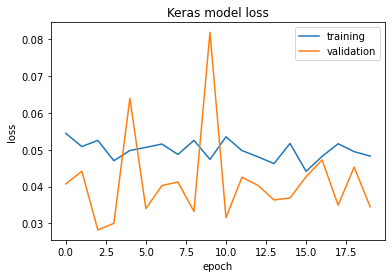

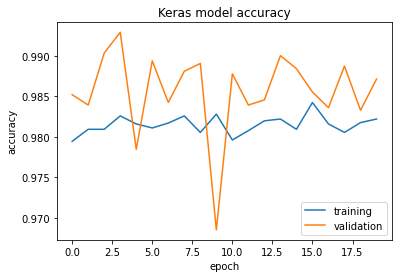

Training completed in time:  0:52:29.291002
Training Accuracy:  0.9984019994735718
Validation Accuracy:  0.9871423840522766


In [10]:
# Training the model

num_epochs = 20
num_batch_size = 50
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(x_val, y_val), callbacks=[checkpointer], verbose=1)
# Visualize History for Loss.
plt.title('Keras model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

duration = datetime.now() - start
print("Training completed in time: ", duration)

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_val, y_val, verbose=0)
print("Validation Accuracy: ", score[1])

### Obtention de la matrice de confusion

In [7]:
# Confusion matrix
X_pred = model.predict(x_test)
y_pred = []
for predicted_proba_vector in X_pred:
    maxi = np.argmax(predicted_proba_vector)
    prediction = le.inverse_transform([maxi])
    y_pred.append(prediction)
y_true = []
for vector in y_test:
    maxi = np.argmax(vector)
    cat = le.inverse_transform([maxi])
    y_true.append(cat)
M = metrics.confusion_matrix(
    y_true, y_pred, labels=['bee', 'queen bee', 'missing queen', 'nobee'],  normalize='true')
print(M)

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.83091787e-04 9.98550725e-01 9.66183575e-04]
 [0.00000000e+00 2.44444444e-02 4.88888889e-02 9.26666667e-01]]


### Sauvegarde du modèle

In [9]:
# Saving the model
model.save('bee_sound_model.h5')

## Etape 5: Prédictions

### Chargement de l'encodage des labels et du modèle

In [11]:
%store -r le
# Loading the model
loaded_model = tf.keras.models.load_model('bee_sound_model.h5')

In [12]:
def return_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    x_test = prediction_feature.reshape(1, num_rows, num_channels)
    X_pred = loaded_model.predict(x_test)
    for predicted_proba_vector in X_pred:
        maxi = np.argmax(predicted_proba_vector)
        prediction = le.inverse_transform([maxi])
        return(prediction[0])

### Test  pour des audios composites

In [13]:
test_dataset_path="C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/TestDataset/missing queen"
liste_adresses_fichiers = glob.glob(test_dataset_path+"/*")
missing_queen=0
nobee=0
for adresse_fichier in liste_adresses_fichiers:
    print(return_prediction(adresse_fichier))
    if 'missing' in str(return_prediction(adresse_fichier)) : 
            missing_queen+=1
    else:
            nobee+=1
print("missing queen", missing_queen)
print("nobee", nobee)

ValueError: cannot reshape array of size 6920 into shape (1,40,1)

## Bonus: visualisation des données

In [1]:
# Load imports

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

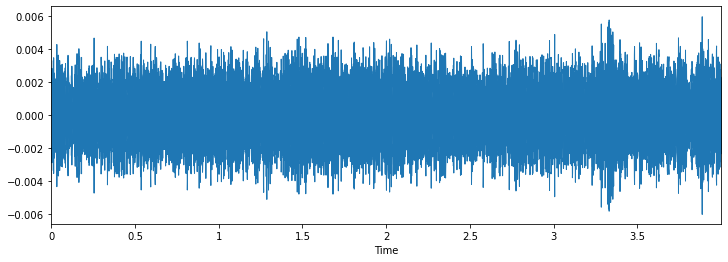

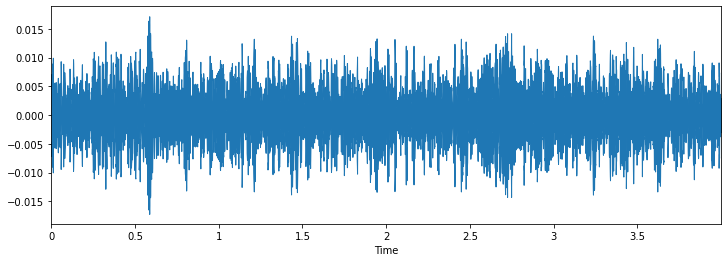

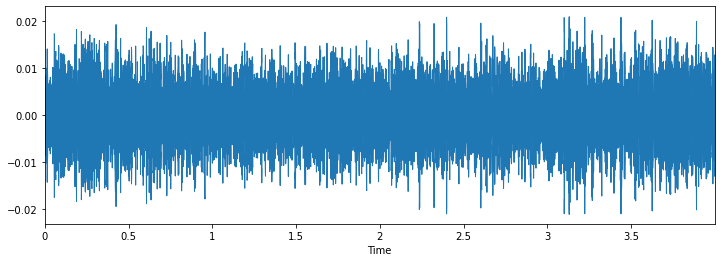

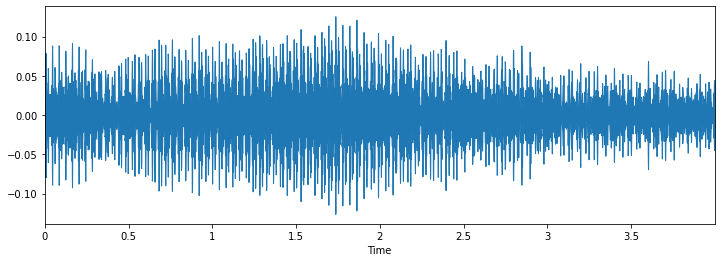

In [2]:
fulldatasetpath = "C:/Users/Max/Documents/CS/Travail/FIBEE/FIBEE Code/Dataset"
filenames = ['/bee/CF003 - Active - Day - (216)_n1_0.wav', 
             '/missing queen/CJ001 - Missing Queen - Day - (100)_n3_0.wav',
             '/queen bee/Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n1_0.wav',
             '/nobee/Hive1_12_06_2018_QueenBee_H1_audio___15_00_00_n8_15.wav']
for filename in filenames:
    filename1=fulldatasetpath+filename
    plt.figure(figsize=(12,4))
    data,sample_rate = librosa.load(filename1)
    _ = librosa.display.waveplot(data,sr=sample_rate)
    ipd.Audio(filename1)